<a id="Subcluster_myeloid"></a>
## Sub-cluster monocytes

- [1. Load raw data and clsutering data](#load)
- [2. Script for processing monocytes](#script)
- [3. Iterative subclustering 1 - removes clear doublets and replicating lymphocytes](#cluster_1)
- [4. Iterative subclustering 2 - removes neutrophils](#cluster_2)
- [5. Iterative subclustering 3 - removes RBCs, platelets, plasmablasts, pDCs, some doublets](#cluster_3)
- [6. Iterative subclustering 4 - remove straggler doublets](#cluster_4)
- [7. Iterative subclustering 5 - final clustering consiting only of monocytes and conventional DCs](#cluster_5)

In [1]:
import os
adir = '../../../../data/ExVivo/Seqwell'
project_name = 'exvivo2_20200318_mmul8_V4'
abase = os.path.join(adir, project_name)
gcs = False
abase

'../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../Code')
from utils import save_adata, read_adata, subcluster_iteration

import palettable
from IPython.display import display

from joblib import parallel_backend

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')

np.random.seed(14)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


<a id="load"></a>

## Load raw data and previous clustering results

In [5]:
annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMB.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(annot_file)

../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.SubclusterMB.h5ad


In [6]:
adata_annot = read_adata(annot_file, gcs=gcs)

Only considering the two last: ['.SubclusterMB', '.h5ad'].
Only considering the two last: ['.SubclusterMB', '.h5ad'].


In [7]:
adata_annot.obs['leiden_lab_group'].value_counts()

Multiplet      25650
Th             17425
B              16867
NK              8133
Tc              5694
Mono/DC         4022
Plasmablast      267
Name: leiden_lab_group, dtype: int64

In [8]:
adata_raw = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
adata_raw = adata_raw[adata_raw.obs['leiden_lab_group'].isin(['Th', 'Tc', 'NK']), :]

adata_raw_full = adata_raw.copy()

adata_raw = adata_raw[:,~(adata_raw.var['Combined_Blacklist'] | adata_raw.var['CC_Blacklist'])]
sc.pp.filter_genes(adata_raw, min_cells=10)

sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw)

sc.pp.normalize_per_cell(adata_raw_full, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw_full)

adata_raw.raw = adata_raw_full

filtered out 2615 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Iteration 1

In [9]:
genestoplot = ['CD3D', 'IL7R', 'GZMB', 'MS4A1', 'IGKC', 'MNDA', 'LYZ', 'MKI67', 'PPBP', 'HBB']

In [10]:
adata_raw.shape[0]

31252

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:09)


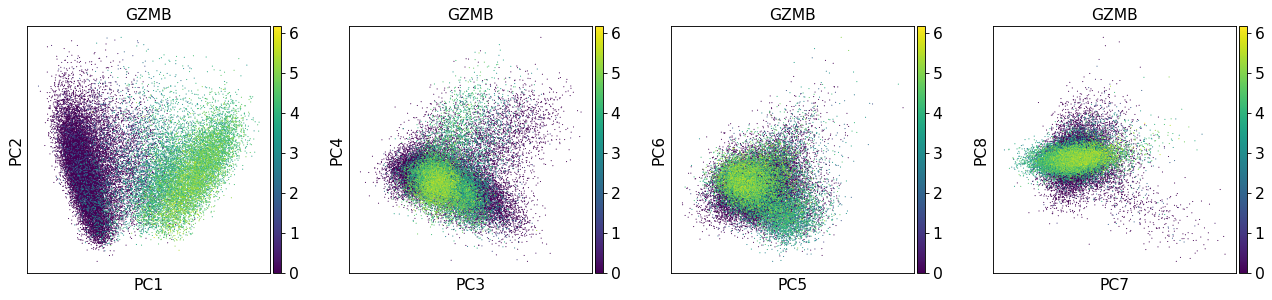

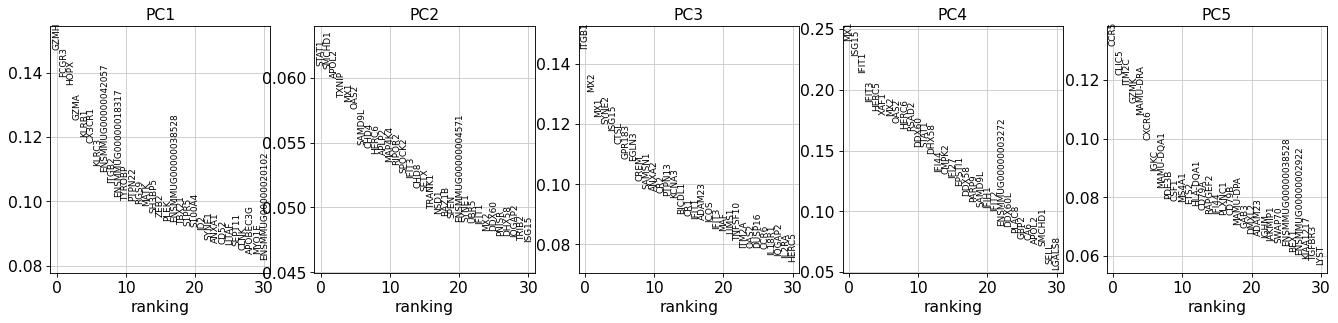

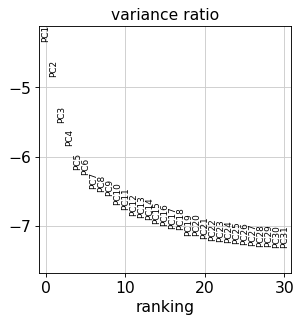

computing neighbors
    using 'X_pca' with n_pcs = 12


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:54)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:29)


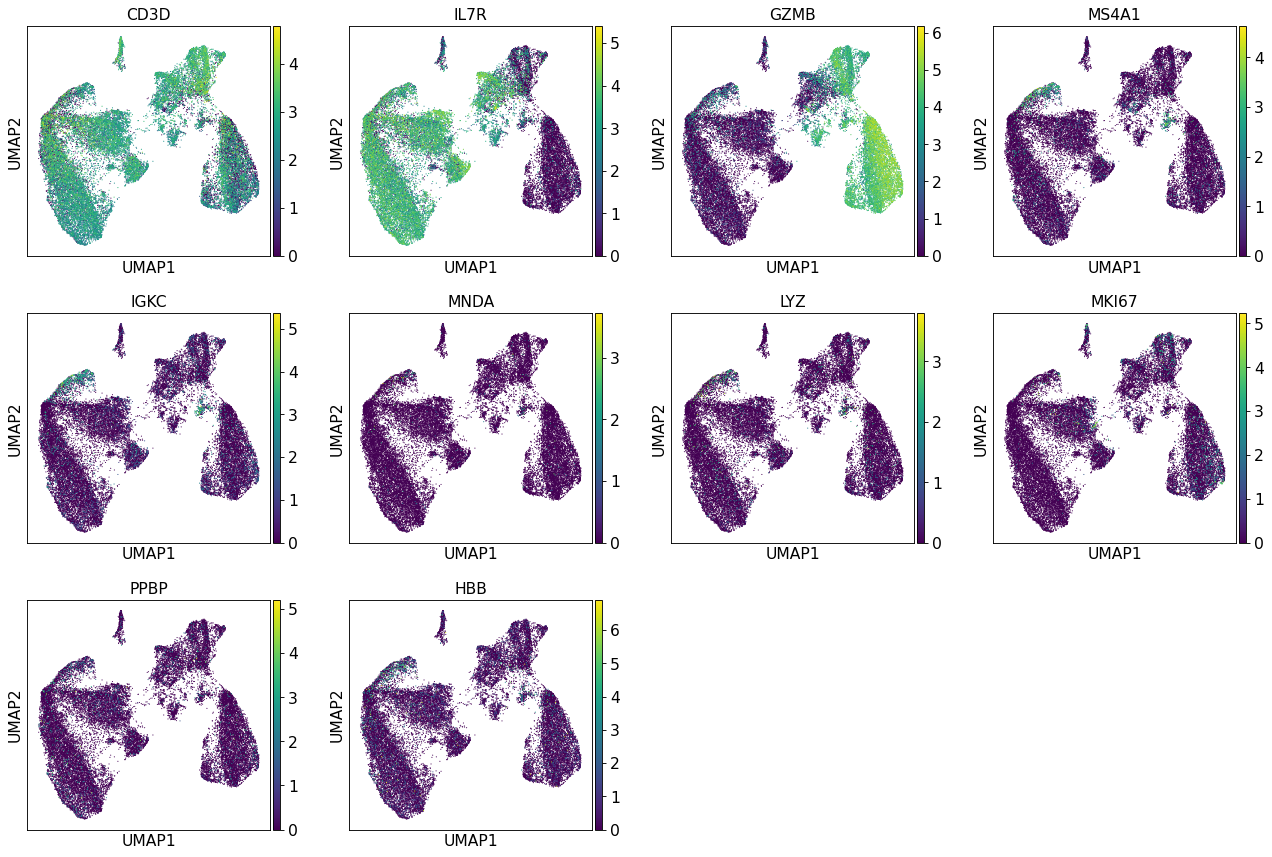

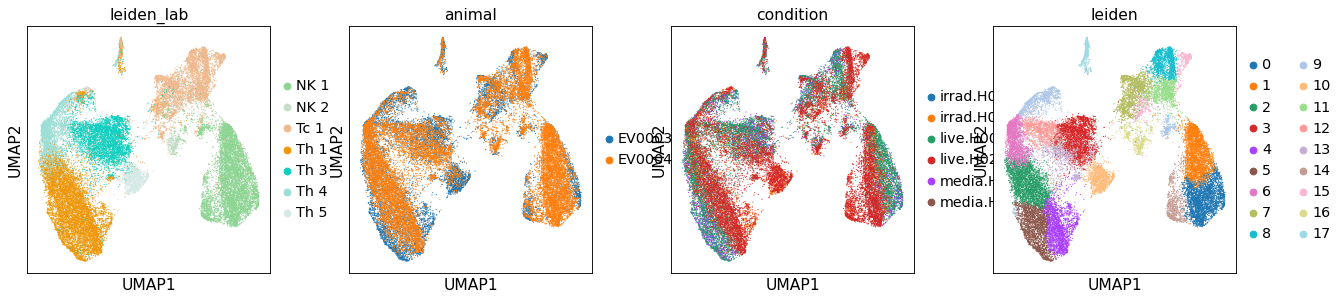

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:51)


0                   1                   2        3  \
0                FCGR3                GZMB                 CA6      VIM   
1                 GNLY                GNLY              RPL27A   GPR183   
2                 GZMB               FCGR3              PECAM1   SPOCK2   
3                 GZMH                HOPX              RPS27A     CREM   
4                 HOPX                GZMH               RPS14    ITGB1   
5                 GZMA               KLRB1                SELL   BICDL1   
6                ITGB2                GZMA               RPL30     FTH1   
7                KLRC3  ENSMMUG00000014256  ENSMMUG00000002676    ITM2A   
8               CX3CR1  ENSMMUG00000042057               RPS15     ICOS   
9                KLRB1               KLRC3                RPS5    SYNE2   
10               RUNX3               ITGB2               RPS16    AP3M2   
11                CD52            PPP1R12A               RPLP2    ANXA2   
12               IL2RB  ENSMMUG00000018317               RPS13     IL7R   
13  ENSMMUG00000042057               ANXA1               RPS23   ARID5B   
14               AHNAK              PTPN22               RPL11   GPRIN3   
15               SYNE1                CD52               RPS19     SRGN   
16              PTPN22                 ID2              RPL13A     ADSL   
17                MATK              TYROBP                TPT1   LAPTM5   
18              TYROBP               RUNX3                RPS7  ZFP36L2   
19                RGS9              CX3CR1               RPL22    LIMS1   

          4       5                   6                   7  \
0      SELL  PECAM1               RPL30                GZMK   
1       CA6    SELL              RPS27A               ITM2C   
2     RFLNB  SPOCK2              RPL13A  ENSMMUG00000038528   
3    PECAM1     CA6              RPL27A              PIK3R1   
4     ITGA6   ITGA6  ENSMMUG00000015270                 EZR   
5      LEF1    LEF1  ENSMMUG00000003867  ENSMMUG00000012140   
6      TCF7   RPL18  ENSMMUG00000002676               ARAP2   
7     PLAC8    RPS3               RPS14               KCNA3   
8      RPS3   EEF1G               RPS16                 VIM   
9   TMEM63A    RPL8               RPL11               LIMS1   
10    TRIB2    ADD3               RPS23                IL7R   
11    EEF1G    IL7R                TPT1                LCP1   
12    SEPT6    TCF7               RPLP2                LYAR   
13   RPL10A   RPS15               RPS13                CCR5   
14     IL7R  SPTBN1               RPS19              TGFBR3   
15   SPTBN1   RPS14                RPS5                LPXN   
16     DGKA   RFLNB                RPS6               IL2RB   
17    DYRK2  RPL10A               RPL27              PLXNC1   
18     RPL8    RPL3               RPL35                BEX1   
19     ADD3  EEF1A1               RPL22               PPM1M   

                     8                   9                  10  \
0                AHNAK            MAMU-DRA                 MX1   
1              S100A10                IGKC                 MX2   
2                 GZMB               MS4A1               ISG15   
3                SYNE1               CD79B               HERC6   
4   ENSMMUG00000038528  ENSMMUG00000028701                OAS2   
5                ITGA4            MAMU-DPA               IFIT1   
6                 GZMH              SWAP70               STAT1   
7               ZBTB38           MAMU-DQA1              RNF213   
8                ITGAL                IGHM               IFIT3   
9               TGFBR3            HLA-DQA1              GIMAP7   
10               CLIC5               IFI30                XAF1   
11                KLF6                FTH1               HELZ2   
12               PTPRC                 HBB               SP100   
13              S100A4            MAMU-DPB  ENSMMUG00000013257   
14               ITGB2                CD19              TRIM22   
15              DNAJC1                CYBB               SYNE2   

In [11]:
adata_1 = subcluster_iteration(adata_raw,
                        min_cells=10,
                        nhvgs=nhvgs, npcs=12,
                        n_neighbors=int(adata_raw.shape[0]*.001),
                        min_dist=0.1, spread=2.0,resolution=1.5,
                        umap_genestoplot=genestoplot, pc_genestoplot=['GZMB'],
                        other_plot=['leiden_lab', 'animal', 'condition', 'leiden'], harmony=False,
                        scale=True)

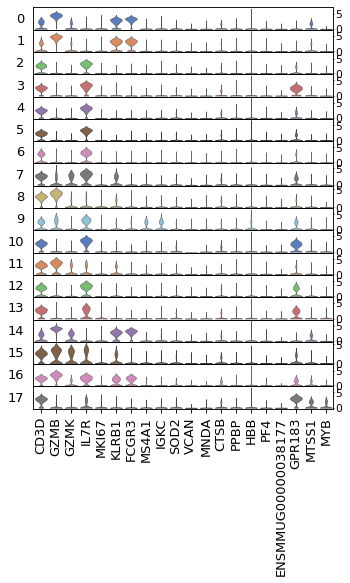

In [12]:
_ = sc.pl.stacked_violin(adata_1, var_names=['CD3D', 'GZMB', 'GZMK', 'IL7R', 'MKI67','KLRB1', 'FCGR3', 'MS4A1', 'IGKC', 'SOD2', 'VCAN', 'MNDA', 'CTSB', 'PPBP', 'HBB', 'PF4', 'ENSMMUG00000038177', 'GPR183', 'MTSS1', 'MYB'], groupby='leiden')

In [13]:
adata_1.obs['leiden'].value_counts()

0     3330
1     3055
2     3032
3     2648
4     2412
5     2393
6     2059
7     1824
8     1513
9     1490
10    1407
11    1258
12    1108
13     981
14     907
15     681
16     639
17     515
Name: leiden, dtype: int64

In [14]:
T_file_initial =  os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.OnlyTNKIter1.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(T_file_initial)

../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.OnlyTNKIter1.h5ad


In [15]:
save_adata(adata_1, T_file_initial, gcs=gcs)

Only considering the two last: ['.OnlyTNKIter1', '.h5ad'].
Only considering the two last: ['.OnlyTNKIter1', '.h5ad'].


In [16]:
list(adata_1.obs['leiden'].unique())

['2',
 '17',
 '9',
 '3',
 '8',
 '7',
 '5',
 '16',
 '1',
 '13',
 '0',
 '6',
 '4',
 '11',
 '12',
 '15',
 '10',
 '14']

In [17]:
adata_annot.obs['Doublet'].unique()

[False, True]
Categories (2, object): [False, True]

In [18]:
doublet_ind = adata_1.obs.index[adata_1.obs['leiden'].isin(['9'])]
adata_annot.obs.loc[:, 'Doublet'] = adata_annot.obs.loc[:, 'Doublet'].astype(str)
adata_annot.obs.loc[doublet_ind, 'Doublet'] = 'True'

<a id="cluster_2"></a>
## Iteration 2

In [19]:
genestoplot2 = ['CD3D', 'GNLY', 'GZMB', 'GZMK', 'GZMA', 'FCGR3', 'KLRB1', 'ITGB1', 'ITGB2', 'SELL', 'FOS', 'MKI67']

filtered out 115 genes that are detectedin less than 10 cells
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:09)


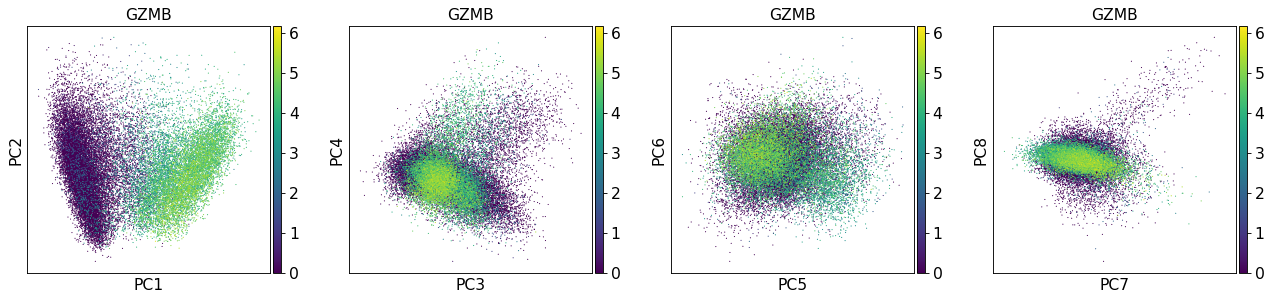

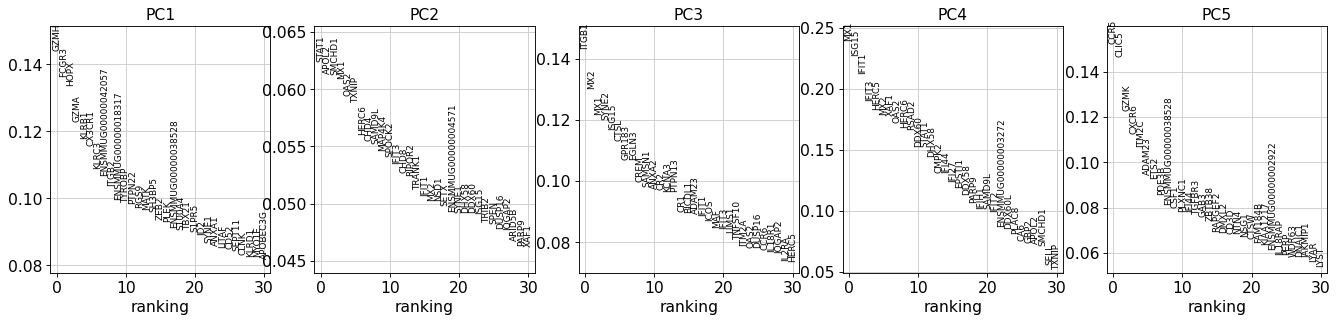

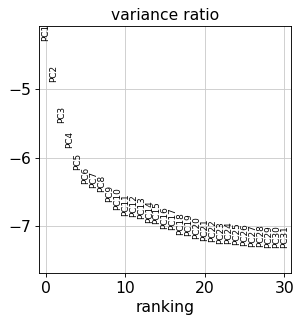

computing neighbors
    using 'X_pca' with n_pcs = 11


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:49)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:42)


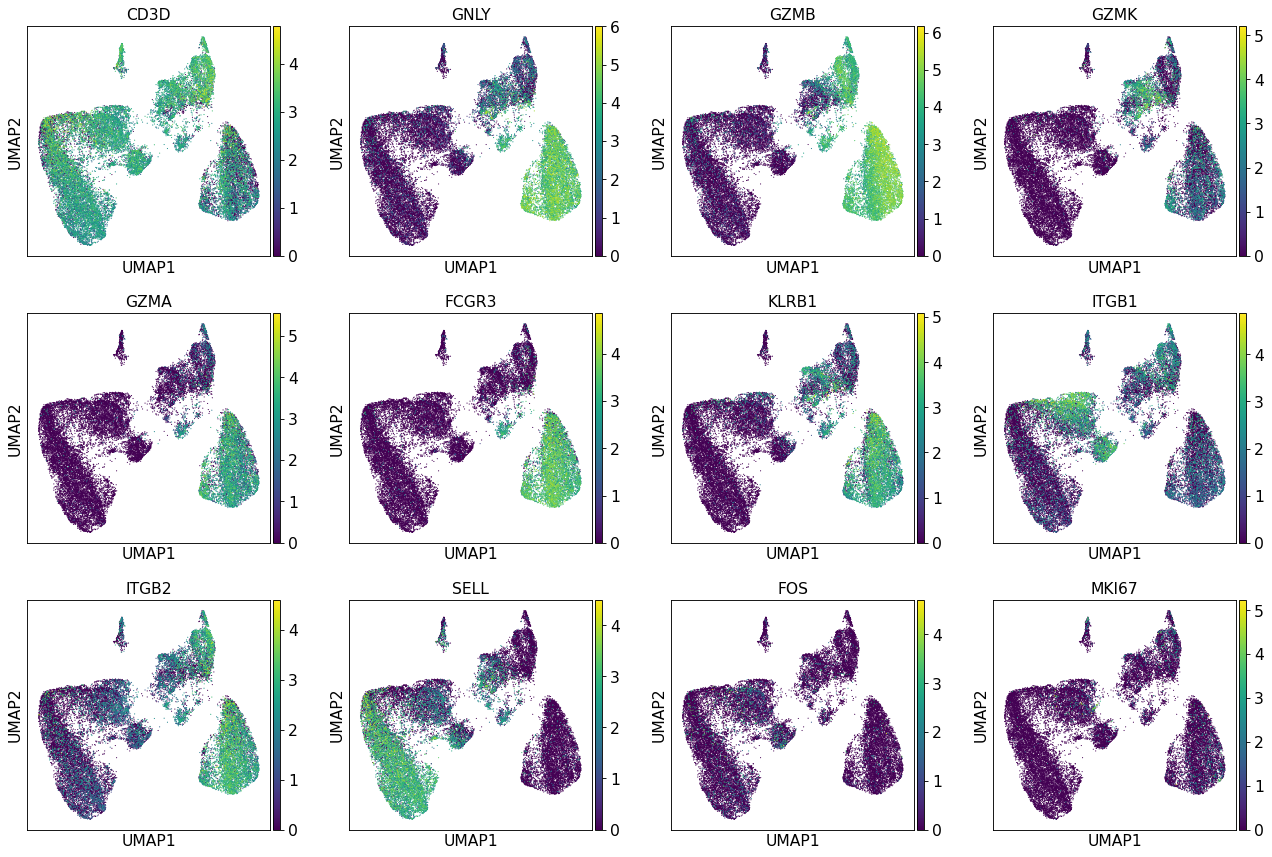

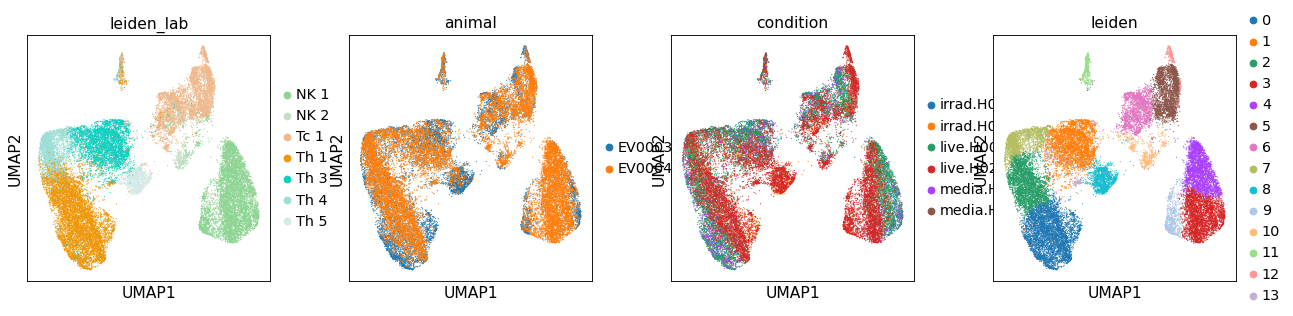

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:46)


0       1                   2                   3  \
0      SELL     VIM              RPS27A               FCGR3   
1       CA6  GPR183               RPL30                GNLY   
2    PECAM1    CREM                 CA6                GZMB   
3     RFLNB  SPOCK2              RPL27A                GZMH   
4     ITGA6   ITGB1               RPS14                HOPX   
5      LEF1   SYNE2                RPS5                GZMA   
6      TCF7  BICDL1  ENSMMUG00000002676               ITGB2   
7      RPS3    ICOS               RPS16               KLRB1   
8     EEF1G    FTH1              PECAM1               KLRC3   
9      IL7R   ITM2A               RPL11              CX3CR1   
10     ADD3    IL7R              RPL13A                CD52   
11     RPL8   ANXA2               RPS23  ENSMMUG00000042057   
12    PLAC8   AP3M2               RPLP2               RUNX3   
13   RPL10A  ARID5B               RPS13               AHNAK   
14    RPL18  GPRIN3               RPS15               IL2RB   
15   SPTBN1  DUSP16                TPT1               SYNE1   
16   SPOCK2   LIMS1               RPS19              PTPN22   
17    RPS15    ADSL  ENSMMUG00000015270              TYROBP   
18  TMEM63A   TRIB2               RPL22                MATK   
19    TRIB2    CTSL               RPL35  ENSMMUG00000018317   

                     4                   5                   6  \
0                 GZMB                GZMB                GZMK   
1                 GNLY             S100A10               ITM2C   
2                FCGR3  ENSMMUG00000038528  ENSMMUG00000038528   
3                 HOPX              TGFBR3              PIK3R1   
4                 GZMH               AHNAK                 EZR   
5                KLRB1               ITGA4  ENSMMUG00000012140   
6   ENSMMUG00000014256            PPP1R12A               KCNA3   
7                 GZMA                CD3D               ARAP2   
8   ENSMMUG00000042057              DNAJC1                LYAR   
9                KLRC3                GZMH                CCR5   
10               ITGB2              ZBTB38                LCP1   
11  ENSMMUG00000018317               SYNE1              TGFBR3   
12               ANXA1               CLIC5               LIMS1   
13            PPP1R12A               ITGAL                IL7R   
14              PTPN22                TTC3                 VIM   
15                 ID2                KLF6             SMARCE1   
16               RUNX3                AIM2               KLRB1   
17                CD52                 ID2                LPXN   
18               IL2RB              S100A4              MAMU-E   
19              SH3BP5               PTPRC              MAMU-B   

                     7                   8       9                  10  \
0               RPL13A                 MX1    GNLY                GZMB   
1                RPL30                 MX2   IFIT1                GZMH   
2                 TPT1               ISG15   FCGR3                GNLY   
3               RPS27A               HERC6    XAF1                HOPX   
4   ENSMMUG00000015270                OAS2   ISG15               FCGR3   
5   ENSMMUG00000003867               STAT1    GZMA               KLRB1   
6                RPL11               IFIT1   SP100                GZMA   
7               RPL27A              RNF213   DDX60  ENSMMUG00000038528   
8                RPS16               IFIT3     MX1               ITGB2   
9                RPS14              GIMAP7    GZMH              CX3CR1   
10               RPS23                XAF1  RNF213                 ID2   
11  ENSMMUG00000002676               HELZ2    GZMB                CD52   
12               RPLP2               SP100   IFIT3                MATK   
13               RPS13  ENSMMUG00000013257   APOL2               ANXA1   
14               RPL27              TRIM22    OAS2              PTPN22   
15               RPS19               SYNE2    HOPX               TBX21   
16               RPS20               DDX6

In [20]:
cells_to_keep = adata_1.obs.index[~adata_1.obs['leiden'].isin(['9'])]

adata_2 = subcluster_iteration(adata_raw[cells_to_keep,:], min_cells=10, nhvgs=nhvgs, npcs=11,
                        n_neighbors=30,
                        min_dist=0.1, spread=2.0,resolution=1.,
                        umap_genestoplot=genestoplot2, pc_genestoplot=['GZMB'],
                        other_plot=['leiden_lab', 'animal', 'condition', 'leiden'],
                        harmony=False, scale=True)

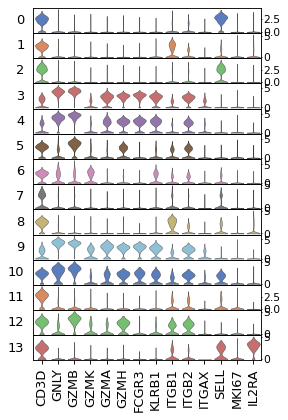

In [21]:
_ = sc.pl.stacked_violin(adata_2, var_names=['CD3D', 'GNLY', 'GZMB', 'GZMK','GZMA', 'GZMH', 'FCGR3', 'KLRB1',  'ITGB1', 'ITGB2', 'ITGAX', 'SELL', 'MKI67', 'IL2RA'], groupby='leiden')

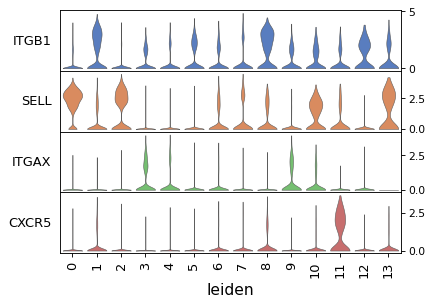

In [22]:
_ = sc.pl.stacked_violin(adata_2, var_names=[ 'ITGB1', 'SELL', 'ITGAX', 'CXCR5'], groupby='leiden', swap_axes=True, figsize=(6,4))

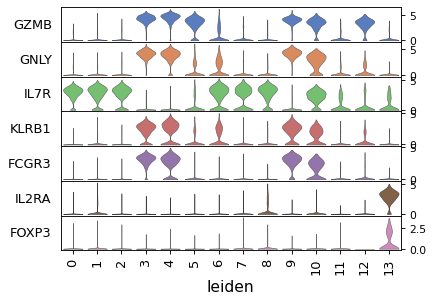

In [23]:
_ = sc.pl.stacked_violin(adata_2, var_names=[ 'GZMB', 'GNLY', 'IL7R', 'KLRB1', 'FCGR3', 'IL2RA', 'FOXP3'], groupby='leiden', swap_axes=True, figsize=(6,4))

In [24]:
labmap = {'0':'Th_ITGB1lo_SELLhi 1',
          '1':'Th_ITGB1hi_SELLlo 1',
          '2':'Th_ITGB1lo_SELLhi 2',
          '3':'NK 1',
          '4':'NK 2',
          '5':'Tc 1',
          '6':'Tc 2',
          '7':'Th_ITGB1mid_SELLmid 1',
          '8':'Th_ITGB1hi_SELLlo 2',
          '9':'NK 3',
          '10':'NK 4',
          '11':'Th_CXCR5hi 1',
          '12':'Tc 3',
          '13':'Treg'}
pd.Series(labmap).value_counts()

Tc 1                     1
NK 1                     1
Treg                     1
NK 2                     1
Th_CXCR5hi 1             1
Tc 2                     1
Th_ITGB1lo_SELLhi 2      1
Th_ITGB1lo_SELLhi 1      1
Th_ITGB1hi_SELLlo 1      1
NK 3                     1
Th_ITGB1mid_SELLmid 1    1
Tc 3                     1
NK 4                     1
Th_ITGB1hi_SELLlo 2      1
dtype: int64

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


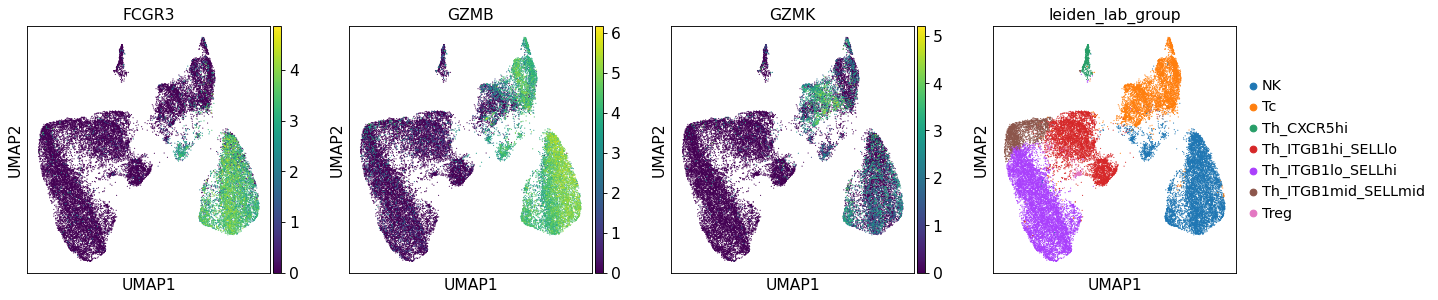

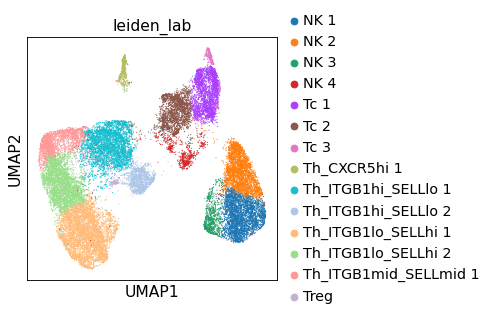

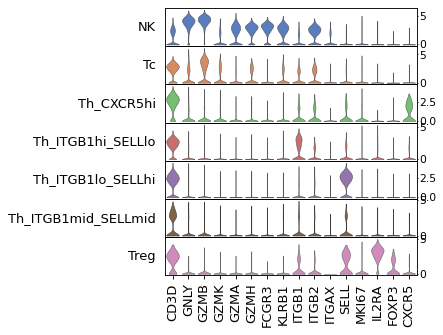

In [25]:
adata_2.obs['leiden_lab'] = adata_2.obs['leiden'].replace(labmap)
adata_2.obs['leiden_lab_group'] = adata_2.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

sc.pl.umap(adata_2, color=['FCGR3', 'GZMB', 'GZMK', 'leiden_lab_group'])
sc.pl.umap(adata_2, color=['leiden_lab'])

_ = sc.pl.stacked_violin(adata_2,
                         var_names=['CD3D', 'GNLY','GZMB', 'GZMK','GZMA', 'GZMH', 'FCGR3', 'KLRB1',  'ITGB1', 'ITGB2', 'ITGAX', 'SELL', 'MKI67', 'IL2RA', 'FOXP3', 'CXCR5'],
                         groupby='leiden_lab_group')

In [26]:
adata_2.obs['leiden_lab_group'].value_counts()

Th_ITGB1lo_SELLhi      8653
NK                     7951
Tc                     5229
Th_ITGB1hi_SELLlo      5203
Th_ITGB1mid_SELLmid    1990
Th_CXCR5hi              495
Treg                    241
Name: leiden_lab_group, dtype: int64

In [27]:
adata_annot.obs['Subclustering'] = adata_annot.obs['Subclustering'].astype(str)
adata_annot.obs['SubclusteringGroup'] = adata_annot.obs['SubclusteringGroup'].astype(str)
adata_annot.obs.loc[adata_2.obs.index, 'SubclusteringGroup'] = adata_2.obs['leiden_lab_group']
adata_annot.obs.loc[adata_2.obs.index, 'Subclustering'] = adata_2.obs['leiden_lab']

In [28]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file)

../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.SubclusterMBTNK.h5ad


In [29]:
save_adata(adata_annot, results_file, gcs=gcs)

Only considering the two last: ['.SubclusterMBTNK', '.h5ad'].
Only considering the two last: ['.SubclusterMBTNK', '.h5ad'].


... storing 'Subclustering' as categorical
... storing 'SubclusteringGroup' as categorical
... storing 'Doublet' as categorical


In [30]:
results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.OnlyTNK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file_sub)

../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.OnlyTNK.h5ad


In [31]:
save_adata(adata_2, results_file_sub, gcs=gcs)

Only considering the two last: ['.OnlyTNK', '.h5ad'].
Only considering the two last: ['.OnlyTNK', '.h5ad'].


In [32]:
pd.crosstab([adata_annot.obs['leiden_lab_group'], adata_annot.obs['Doublet']], adata_annot.obs['SubclusteringGroup'])

SubclusteringGroup        B_Memory  B_Naive  Mono    NK  Plasmablast    Tc  \
leiden_lab_group Doublet                                                     
B                False       11952     3724     0     0            7     0   
                 True            0        0     0     0            0     0   
Mono/DC          False           0        0  2606     0            0     0   
                 True            0        0     0     0            0     0   
Multiplet        False           0        0     0     0            0     0   
NK               False           0        0     0  7679            0   215   
                 True            0        0     0     0            0     0   
Plasmablast      False          12        0     0     0          252     0   
                 True            0        0     0     0            0     0   
Tc               False           0        0     0   249            0  4836   
                 True            0        0     0     0            0     0   
Th               False           0        0     0    23            0   178   
                 True            0        0     0     0            0     0   

SubclusteringGroup        Th_CXCR5hi  Th_ITGB1hi_SELLlo  Th_ITGB1lo_SELLhi  \
leiden_lab_group Doublet                                                     
B                False             0                  0                  0   
                 True              0                  0                  0   
Mono/DC          False             0                  0                  0   
                 True              0                  0                  0   
Multiplet        False             0                  0                  0   
NK               False             5                  7                  0   
                 True              0                  0                  0   
Plasmablast      False             0                  0                  0   
                 True              0                  0                  0   
Tc               False           238                 96                 24   
                 True              0                  0                  0   
Th               False           252               5100               8629   
                 True              0                  0                  0   

SubclusteringGroup        Th_ITGB1mid_SELLmid  Treg  cDC    nan  
leiden_lab_group Doublet                                         
B                False                      0     0    0      0  
                 True                       0     0    0   1184  
Mono/DC          False                      0     0  406      0  
                 True                       0     0    0   1010  
Multiplet        False                      0     0    0  25650  
NK               False                      2     0    0      0  
                 True                       0     0    0    225  
Plasmablast      False                      0     0    0      0  
                 True                       0     0    0      3  
Tc               False                     28     0    0      0  
                 True                       0     0    0    223  
Th               False                   1960   241    0      0  
                 True                       0     0    0   1042

In [33]:
adata_annot.obs['Doublet'].value_counts()

False    74371
True      3687
Name: Doublet, dtype: int64